# Прогнозы и предсказания

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. 

Чтобы бороться с оттоком клиентов, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. На их основе необходимо провести анализ и подготовить план действий по удержанию клиентов.


А именно:
    1. научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
    2. сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
    3. проанализировать основные признаки, наиболее сильно влияющие на отток;
    4. сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
        1) выделить целевые группы клиентов;
        2) предложить меры по снижению оттока;
        3) определить другие особенности взаимодействия с клиентами.

## Этап 1. Загрузка данных

«Культурист-датасаентист» предоставил сведения в csv-файлах. В файле содержатся данные за месяц до оттока и факт оттока на определённый месяц.

In [1]:
# импорт необходимых библиотек
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from scipy import stats as st
import numpy as np
from datetime import datetime
import math

np.warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')

Приведем названия столбцов к нижнему регистру для лучшей читаемости и выведем данные для просмотра.

In [3]:
df.columns = df.columns.str.lower()
df.sample(5)

In [4]:
df.shape

In [5]:
df[df.duplicated(keep=False)].shape

In [6]:
df.info()

Данный тип задач - обучение с учителем, кластеризация.

На входе есть 4 тысячи строк (объектов) по 14 признакам, включая целевой:

    'Churn' — факт оттока в текущем месяце;
    'gender' — пол
    'Near_Location' — проживание или работа в районе, где находится фитнес-центр
    'Partner' — сотрудник компании-партнёра клуба 
    'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга»
    'Phone' — наличие контактного телефона
    'Age' — возраст
    'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
    'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
    'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
    'Group_visits' — факт посещения групповых занятий
    'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
    'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
    'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра
    
Все признаки уже переведены в числовые. Дубликатов в данных нет.

## Этап 2.  EDA. Анализ качества признаков

Для проведения исследовательского анализа данных посмотрим на датасет. В нем нет пропущенных признаков (все 4 тыс.записей).

In [7]:
df.isnull().sum()

Посмотрим среднее значение и стандартное отклонение признаков общего датасета (**all**), тех, кто ушел из клуба (**1**), и тех, кто остался (**0**).

In [8]:
def agg(df):
    return df.agg([np.mean, np.std]).T.round(3)

(pd.concat([agg(df), 
            agg(df.query('churn == 1')), 
            agg(df.query('churn == 0'))], 
            axis=1)
   .set_axis(['mean_all', 'std_all', 'mean_1', 'std_1', 'mean_0', 'std_0'], axis=1, inplace=False))

Так как среднее **mean** - это способ описать центральное значение ряда наблюдений, а **std** - это среднее отклонение наблюдений от среднего, можно сделать следующе выводы: 

**Портрет пользователей, ушедших в отток**:
- средний возраст клиентов, попадающих в отток, - 26 лет
- в среднем они заключают договор длительностью до 2 месяцев
- не увлекаются групповыми занятиями
- выручка от основной массы клиентов отличается от среднего значения более чем на 77%
- перестают посещать фитнес-клуб за полтора месяца до окончания срока действия договора
- в среднем занимались спортом в клубе месяц
- приходили 1,5 раза в неделю в клуб
- за последний месяц приходили один раз в клуб

**Портрет оставшихся пользователей**:
- средний возраст клиентов - 30 лет
- в среднем они заключают договор длительностью 6 месяцев
- половина клиентов увлекаются групповыми занятиями
- выручка от основной массы клиентов отличается от среднего значения более чем на 99%
- в среднем занимались спортом в клубе 5 месяцев
- приходили 2 раза в неделю в клуб, в том числе за последний месяц

Переменные Group_visits, Age и Avg_additional_charges_total имеют разные средние значения и стандартныее отклонения. После деления выборки на обучающую и валидационную, необходимо провести стандартизацию (внизу).

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).
Чтобы сделать для каждого признака "персонализированный" график, задаем размер корзины как количество уникальных значений каждого признака.

Далее мне понадобится еще раз строить графики распределения, так что логичнее написать функцию **disp()** и применять ее сколько угодно раз.

In [9]:
# вынесла в функцию постороение гистограммы, для каждого графика задала размер корзины = кол-во уникальных признаков
def disp(groupby_col, histtype, suptitle):
    fig, ax = plt.subplots(5, 3, figsize=(15,25))
    ax = ax.flatten()
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    for i, col in enumerate(df.drop(['churn'], axis=1)):
        df.groupby(groupby_col)[col].plot(kind='hist',
                                      bins= df[col].nunique(),
                                      alpha=1, 
                                      histtype = histtype, 
                                      title = str(col),
                                      ax = ax[i])
        fig.suptitle(suptitle, y = .94, fontsize=20)
        fig.legend(labels=df[groupby_col].unique(), loc=(.37, 0.945), ncol=5)

    plt.show()

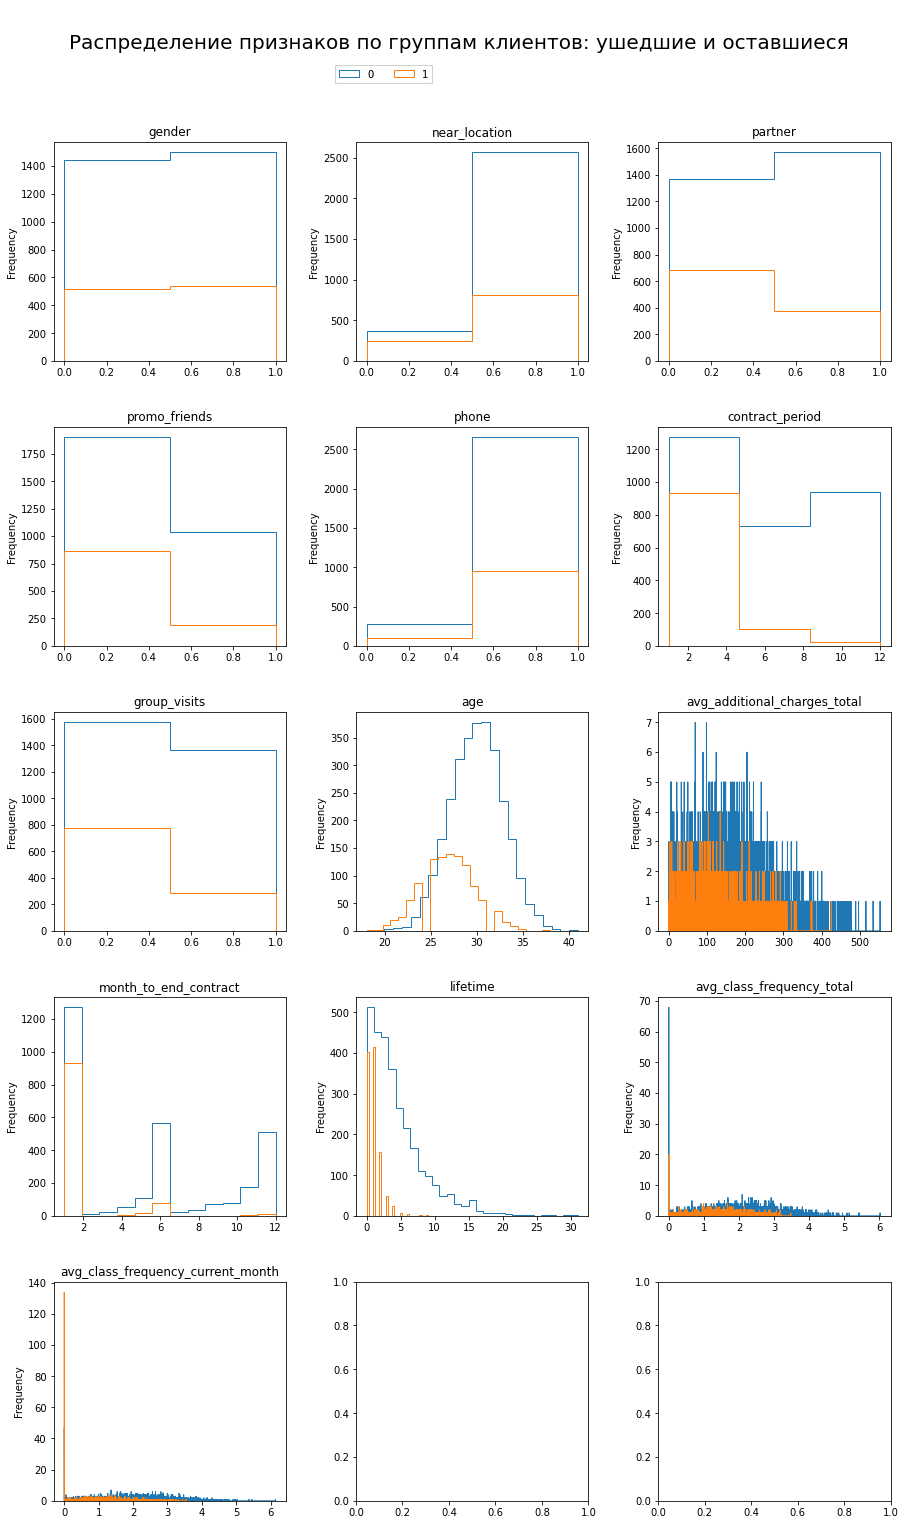

In [10]:
disp('churn', 'step', 'Распределение признаков по группам клиентов: ушедшие и оставшиеся')

Признаков по тем клиентам, что остались в клубе, больше (73%), чем по тем, кто ушел в отток (27%). Это видно по графикам выше. А еще заметно, что вне зависимости от того, остался клиент в клубе или покинул его, в среднем он посещает клуб один раз в неделю (последние два графика).

Посмотрим на матрицу корреляции.

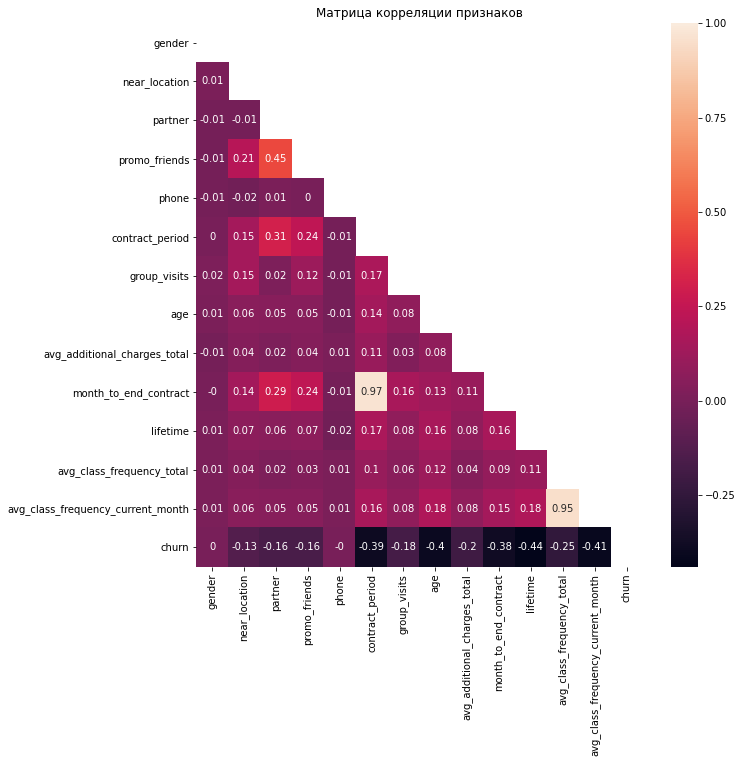

In [11]:
plt.figure(figsize=(10, 10))
matrix = np.triu(df.corr())
sns.heatmap(df.corr().round(2), annot=True, mask = matrix)
plt.title('Матрица корреляции признаков');

Есть взаимосвязь между временем до окнчания контракта и длительностью контракта, что логично (по факту это один и тот же признак). Незначительная связь между сотрудниками компании-партера клуба и наличия акции "приведи друга".
У остальных признаков нет связи между собой или она очень слабая (например, сотрудник компании-партнера и время до окончания договора).

На основании матрица корреляции и графиками по признкам, можно сделать вывод, что на факт оттока клиентов вляют:
* длительность контракта (чем она выше, тем ниже шанс ухода клиента);
* возраст клиента (чем старше клиент, тем он дисциплинированее);
* время до окончания договора (так же обратная зависимость);
* время с первого посещения клиента (чем дольше ходит клиент, тем меньше вероятность его ухода);
* средняя частота посещений в неделю за последний месяц.

Абсолютно не важно, есть ли у клуба информация по номеру телефона клиента или его гендеру.

## Этап 3. Модель прогнозирования оттока пользователей

Построим модель бинарной классификации пользователей. Для этого разобьем данные на обучающую **train** и валидационную **test** выборку функцией train_test_split()

In [12]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']

#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=0)

# обучаем StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Чтобы получить фиксированный "раскол" данных на выборки, добавила параментр random_state.

Обучим модель двумя способами: логистической регрессией и случайным лесом. Выведем для каждой модели метрики Accuracy (доля правильных ответов) и Recall (полнота).

In [13]:
def fit_model(model, title):
    
    # зададим алгоритм для модели
    model = model
    
    # обучим модель
    model.fit(X_train_st, y_train)
    
    # воспользуемся уже обученной моделью, чтобы сделать прогнозы
    predictions = model.predict(X_test_st)   # бинарный прогноз
    probabilities = model.predict_proba(X_test_st)[:,1]   # оценка вероятности принадлежности классу 1 (отток клиентов)
    
    # выведем метрики Accuracy и Recall
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('\tRecall: {:.2f}'.format(recall_score(y_test, predictions)))

In [14]:
fit_model(LogisticRegression(), 'Метрики для модели логистической регрессии:')

In [15]:
fit_model(RandomForestClassifier(n_estimators = 100), 'Метрики для модели случайного леса:')

Доля правильных ответов у модели **логистической регрессии** выше (при балансе классов), как и полнота (то есть сколько реальных объектов с оттоком смогла обнаружить модель).

## Этап 4. Кластеризация пользователей

Кластеризация поможет выделить группы клиентов и предложить по каждому серменту походящий вариант работы с ним.
Однако сперва хорошо бы привести признаки к единому масштабу. Стандартизируем данные - приведем значения признаков к виду стандартного нормального распределения: значения будут центрированы относительно 0, а средний разброс данных составит 1.

In [16]:
# создаём объект класса scaler (нормализатор)
scaler = StandardScaler() 

# обучаем нормализатор и преобразуем набор данных
x_sc = scaler.fit_transform(df.drop(columns = ['churn'])) 

На выходе получим преобразованные таблицы объект-признак для обучающего и валидационного набора. И уже их будем применять для обучения и прогнозирования. После преобразования выборка стала выглядеть вот так:

In [17]:
print(x_sc[:5])

Последовательно объединим близкие кластеры.
Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. 

In [18]:
linked = linkage(x_sc, method = 'ward')

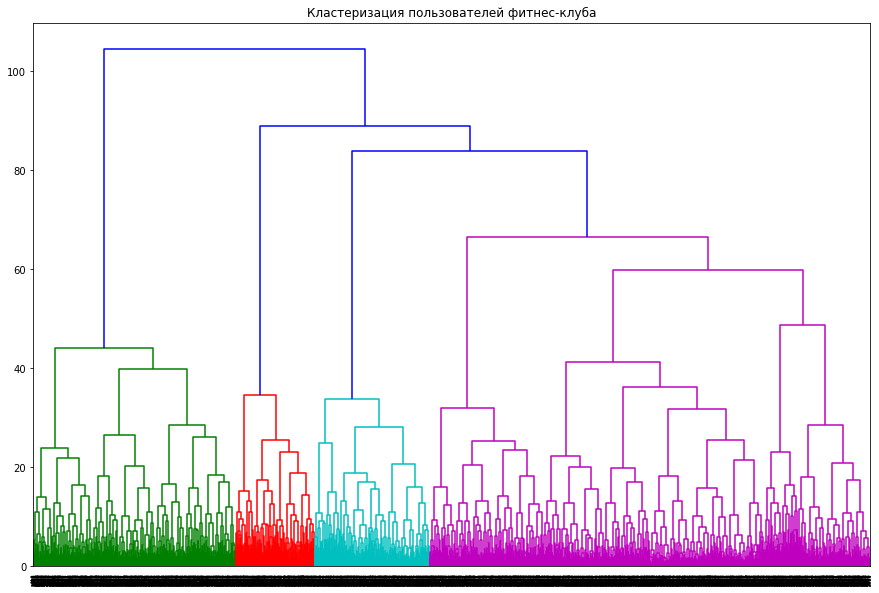

In [19]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей фитнес-клуба')
plt.show()

По дендрограмме можно визуально оценить, сколько кластеров должно быть. А также прикинуть расстояние, после которого мы перестаём объединять объекты. Предложенное оптимальное число кластеров на основании графика выше **4** - четыре разных цветов на графике.

Сложность агломеративной кластеризации заключается не в устройстве самого алгоритма, а в вычислениях, которые машина совершает для построения дендрограммы. Расчёты попарных расстояний могут занять очень много времени. Потому при решении задачи кластеризации полезно строить дендрограмму на случайной подвыборке, а после оценки оптимального числа кластеров запустить более быстрый алгоритм K-Means.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Алгоритм основан на предположении, что число кластеров (групп) заранее известно, поэтому зададим число кластеров - 5.

In [20]:
# задаём число кластеров, равное 5
km = KMeans(n_clusters = 5, random_state = 1) 

# применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(x_sc) 

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster_km').mean().round(3).reset_index().T

Применила алгоритм к стандартизированным данным x_sc.

Если смотреть на средние значения признаков для кластеров можно заметить, что для большинства признаков среднее значение по кластерам отличается (кроме гендера, локации, телефона).

Посмотрим метрику силуэта для нашей кластеризации:

In [21]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(x_sc, labels)))

Значение метрики маленькое, но судя по графикам (ниже) нет четко отделяемых групп на попарных графиках.

Построим распределения признаков для кластеров.

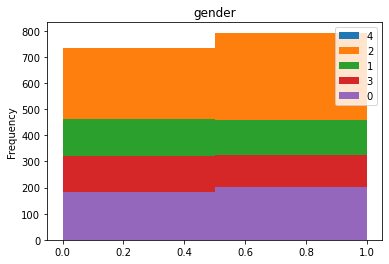

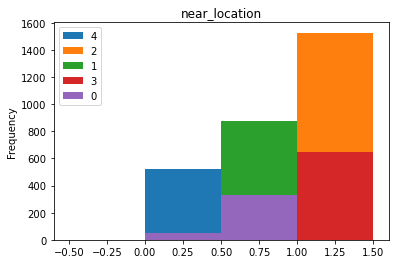

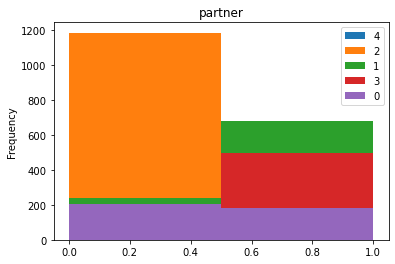

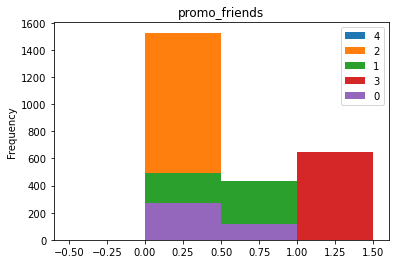

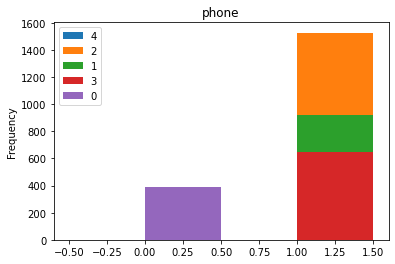

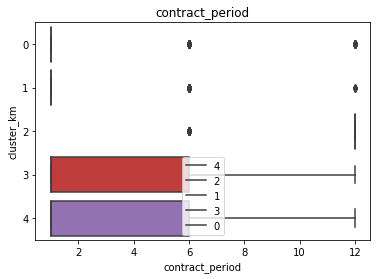

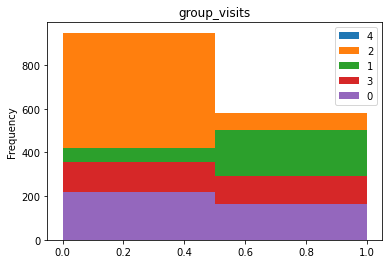

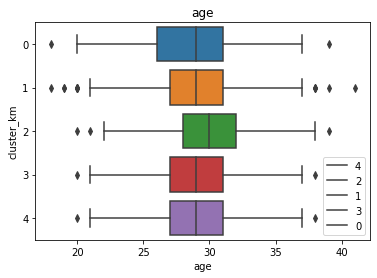

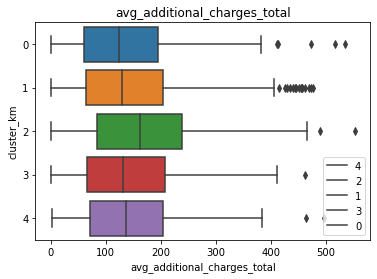

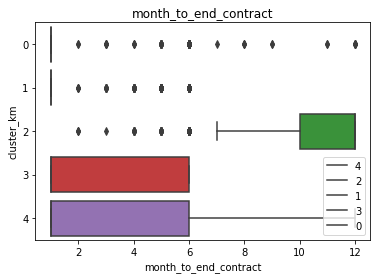

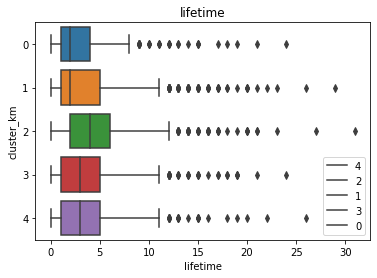

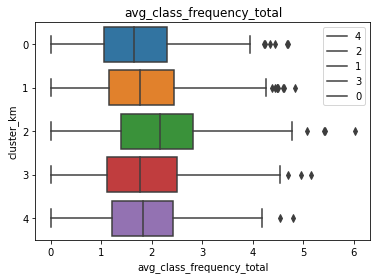

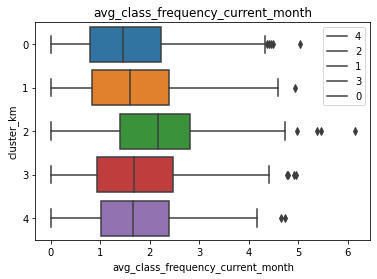

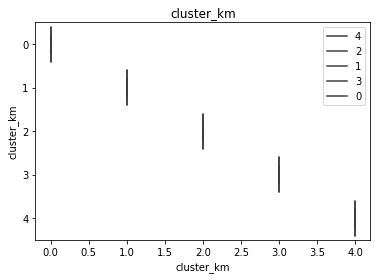

In [22]:
df_1 = df.drop(['churn'], axis=1)
for i, col in enumerate(df_1):
    if df[col].nunique() != 2:
        sns.boxplot(data = df_1, x = col, y = 'cluster_km', orient = 'h')
        plt.title(str(col))
#         fig.suptitle('suptitle', y = .94, fontsize=20)
        plt.legend(labels=df['cluster_km'].unique())
    else:
        df_1.groupby('cluster_km')[col].plot(kind='hist',
                                      bins= df[col].nunique(),
                                      alpha=1, 
                                      histtype = 'bar', 
                                      title = str(col))
        plt.legend(labels=df['cluster_km'].unique())
    plt.show()

  
**Кластер "0"**:
- фитнес-клуб находится не в районе проживания (работы);
- являются клиентам-партнерами клуба;
- почти не задействованы в акции "Приведи друга"
- договор заключен на срок до 3 мес;
- редко не посещают групповые занятия;
- клиент до 29 лет;
- меньше всего из кагорт тратят деньги на другие сервисы клуба;
- до конца окончания договора осталось 2 мес;
- занимаются спортом до 2х раз в неделю;


**Кластер "1"**:
- у всех клуб находится рядом с домом\работой;
- скорее всего не являются партнером;
- абсолютно точно не являются участником акции "Приведи друга";
- заключают договор до 2 мес;
- иногда посещают групповые знаятия;
- до 29 лет;
- на равне с когортами 3,4 тратят на сервисы клуба;
- до конца окончания договора меньше 2 мес;
- повещают клуб уже более 3 мес;
- ходят в клуб до 2х раз в неделю, но в последнее время - до 1.5;


**Кластер "2"**:
- с большей вероятностью занимаются рядом с домом или работой;
- являются партнером клуба;
- и возможно (более 46%) - участником акции;
- заключили договор на 12 мес (молодцы какие!);
- периодически посещают групповые занятия;
- до 30 лет;
- больше дургих тратят деньги на другие услуги клуба;
- им еще заниматься более 10 мес;
- уже отходили пости 5 мес;
- занимаются спортом более 2 раз в неделею (стабильно);


**Кластер "3"**:
- асболютно точно живут рядом с клубом или работают;
- все участники акции "Приведи друга" и партнеры клуба;
- до конца договора осталось еще 3 мес;
- регулярно посещают групповые занятия;
- примерно 29 лет;
- выше среднего по когортам трятя деньги на другие услуги клуба;
- осталось заниматься до 3 мес, а уже приводят себя в порядок 4 мес;
- ходят до 2х раз в неделю в клуб;


**Кластер "4"**:
- скорее всего рядом с работой или домом находится клуб;
- возможно являются партнером или участником акции;
- не оставляют своих контактов в клубе (чтобы не заставили заниматься));
- договор до 5 мес;
- иногда посещают групповые занятия;
- в среднем 29 лет;
- покупают другие услуг клуба;
- до конца занятий в клубе остается 5 мес, а уже ходят почти 4 мес;
- стараются посещать клуб до 2х раз в неделю.

Для каждого кластера посчитаем долю оттока.

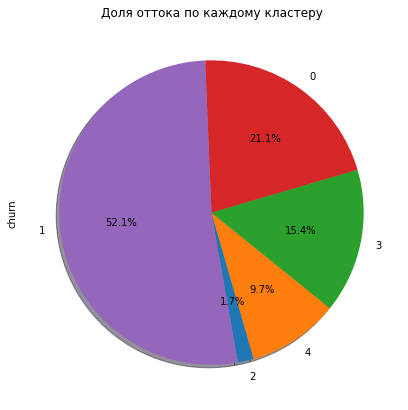

In [23]:
cluster_rate = (df.groupby(['cluster_km'])[['churn']].sum()
                 .apply(lambda x: x/x.sum())
                 .reset_index()
                 .sort_values('churn'))

fig = plt.figure(figsize=(7,7))
cluster_rate.churn.plot.pie(shadow=True, 
                            startangle=280, 
                            autopct='%1.1f%%',
                            title = 'Доля оттока по каждому кластеру');

Самые склонные к оттоку кластеры - 1 и 3. Самые "стойкие" клиенты фитнес-клуба те, что попали в 4-ый кластер.

## Этап 5. Выводы и базовые рекомендации по работе с клиентами

В итоге можно нарисовать "портрет" клиента, который с большей вероятностью забросит занятия спортом в фитес-клубе:
- с большей вероятностью является клиентом-партнером;
- контракт заключает в среднем на 5 месяцев;
- средний возраст - 28 лет (это попытки привести себя в порядок до 30-ти :)
- бросает заниматься спортом за 4 месяца до окончания договора на 3-ей месяце занятия;
- посещает клуб два раза в неделю, и 1,5 раза за последний месяц

Если сравнивать этот портрет с 4-тым кластером, то можно заметить, что клиенты посещают фитнес-клуб еще и ради других услуг, а щее они чаще посещают клуб еженедельно.

Все логично: если поставить себе в привычку регулярные занятия спортом и еще мотивировать себя массажным салоном, кафе и другими "плюсами" фитнес-клуба, клиент останется на весь срок действия договора.

В связи с этим, необходимо напоминать клиентам о приятных бонусах клуба и мотивировать их на увеличение посещаемости зала в течение недели. Это может быть смс-рассылка, напоминание о графике работы клуба в мобильном приложении или просто "холодные" звонки.